In [54]:
from tensorflow import keras
from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.regularizers import l2,l1
import os
import numpy as np 
import pandas as pd
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
import random
from sklearn.metrics import classification_report,accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/MyDrive/7150/Project

/content/drive/MyDrive/7150/Project


In [ ]:
# !unzip data.zip

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
TRAIN_PATH = "melanoma_cancer_dataset/train"
TEST_PATH = "melanoma_cancer_dataset/test"
IMAGE_SIZE = (150,150)

In [5]:
train_ds = image_dataset_from_directory(
    directory=TRAIN_PATH,
    labels='inferred',
    label_mode='binary',
    validation_split=.2,
    batch_size=32,
    image_size=IMAGE_SIZE,
    seed=123,
    subset='training')
val_ds = image_dataset_from_directory(
    directory=TRAIN_PATH,
    labels='inferred',
    label_mode='binary',
    validation_split=.2,
    batch_size=32,
    image_size=IMAGE_SIZE,
    seed=123,
    subset='validation')

Found 9605 files belonging to 2 classes.
Using 7684 files for training.
Found 9605 files belonging to 2 classes.
Using 1921 files for validation.


In [43]:
test_ds = image_dataset_from_directory(
    directory=TEST_PATH,
    labels='inferred',
    label_mode='binary',
    shuffle='false',
    batch_size=32,
    image_size=IMAGE_SIZE)

Found 1000 files belonging to 2 classes.


# DATA EXPLORATION

* We will look at different images of the malignant and benign set to have a clearer understanding of why they are labelled in such way

In [12]:
TO_LIST = [("Train set", train_ds,TRAIN_PATH), ("Test set", test_ds,TEST_PATH)]

for foldertype,dataset,path in TO_LIST:
    folders = ([name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))])
    print(foldertype)
    total = 0
    for folder in folders:
        contents = os.listdir(os.path.join(path,folder)) 
        print(folder,len(contents))
        total += len(contents)
    print("Total file: ",total)
    print("Used: ",len(dataset.file_paths))
    print()

Train set
benign 5000
malignant 4605
Total file:  9605
Used:  7684

Test set
benign 500
malignant 500
Total file:  1000
Used:  1000



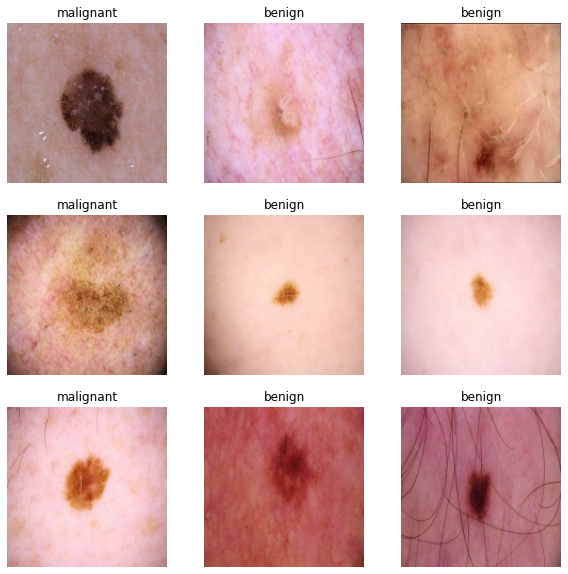

In [13]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i][0])])
        plt.axis("off")

* After several rounds of inspections, it seems that the malignant moles are darker in color, have raised surface as well as a more "blooming" pattern 

* Referencing the codes from "Exploring Breast Cancer images" (https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2) , we will attempt to look at the images in an aggregated fashion. We will first convert the images into numpy arrays.

In [70]:
# get first 100 files
benign_imgs = glob.glob(f'{TRAIN_PATH}/benign/*')[:100]
malignant_imgs = glob.glob(f'{TRAIN_PATH}/malignant/*')[:100]

In [71]:
def convert_to_numpy(all_files, image_size):
    agg_img = None
    for file in all_files:
        this_image = image.load_img(file, target_size = image_size,color_mode = 'grayscale')
        img_arr = image.img_to_array(this_image)
        img_arr = [img_arr.ravel()]
        if agg_img is None:
          agg_img = img_arr
        else:
          agg_img = np.concatenate((agg_img, img_arr))
    return agg_img

In [72]:
benign_agg_image = convert_to_numpy(benign_imgs,(64,64))
malignant_agg_image = convert_to_numpy(malignant_imgs,(64,64))

* To find an average image, we will then divide all the numpy matrixes and then display them

In [73]:
def get_mean(agg_image,image_size):
    mean_img = np.mean(agg_image, axis = 0)
    mean_img = mean_img.reshape(image_size)
    return mean_img 
mean_benign = get_mean(benign_agg_image,(64,64))
mean_malignant = get_mean(malignant_agg_image,(64,64))

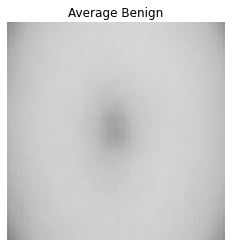

In [74]:
plt.imshow(mean_benign, vmin=0, vmax=255, cmap='Greys_r')
plt.title(f'Average Benign')
plt.axis('off')
plt.show()

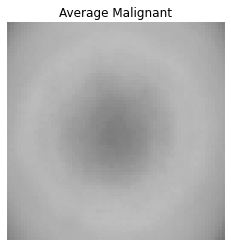

In [75]:
plt.imshow(mean_malignant, vmin=0, vmax=255, cmap='Greys_r')
plt.title(f'Average Malignant')
plt.axis('off')
plt.show()

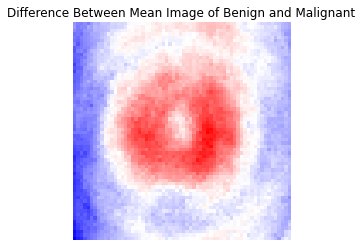

In [76]:
contrast_mean = mean_benign - mean_malignant
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Mean Image of Benign and Malignant')
plt.axis('off')
plt.show()

### Observation
- This helps to strengthen our hypothesis that the malignant melanoma tends to have a more "blooming" pattern in a mushroom shape, as compared to the vertically grown patch of benign melanoma

# USING DEEP LEARNING TO CLASSIFY BENIGN AND MALIGNANT MELANOMA

* For data augmentation, we want to make sure that the images are manipulated in several ways. From our exploration, we see that the moles could be off centered, flattened or skew

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.5),
        layers.RandomTranslation(0.2,0.2),
        layers.RandomZoom(0.2,0.2),
    ]
)

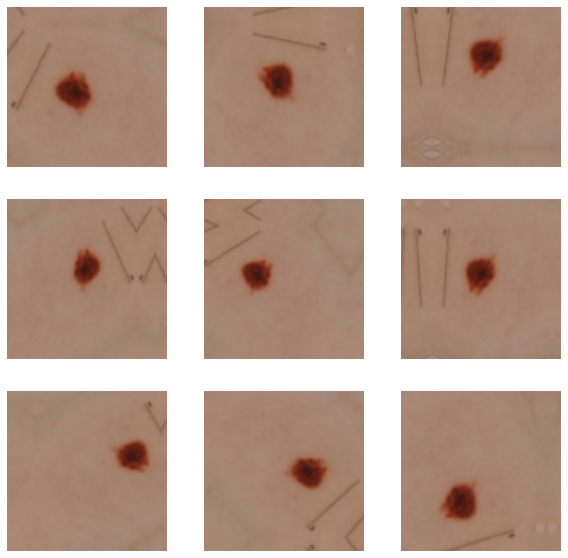

In [81]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

* Thus we can see that the images are sufficiently diverse for training purpose

# BASELINE: FULLY CONNECTED LAYERS

In [8]:
# From previous assignments, we know that slow learning rate is better for SGD
optimizerSGD = tf.keras.optimizers.SGD(learning_rate=0.001,                      
                                  momentum=0.001,                 
                                  decay=0.001)

In [90]:
K.clear_session()
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
# normalization
x = layers.Rescaling(1./255)(inputs)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
fc_model = keras.Model(inputs=inputs, outputs=outputs)

In [91]:
fc_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 1024)              69121024  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0     

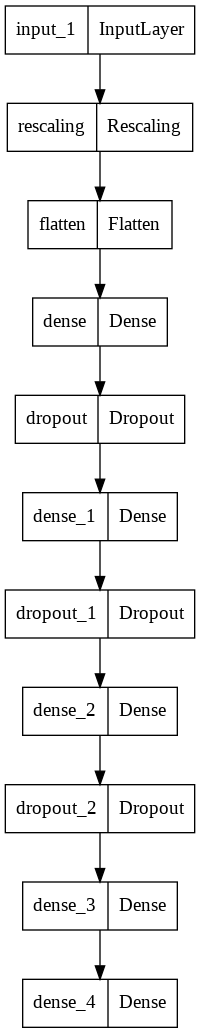

In [92]:
plot_model(fc_model,'fc_model.png')

In [96]:
fc_model.compile(optimizer=optimizerSGD,
             loss='binary_crossentropy',
             metrics=['accuracy'])
callbacks = [
   keras.callbacks.ModelCheckpoint(
       filepath="fc.keras",
       save_best_only=True,
       monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.001, verbose=1,cooldown=1)
]
history_fc = fc_model.fit(
   train_ds,
   epochs=20,
   validation_data=val_ds,
   verbose = 1,
   shuffle=True,
   callbacks=callbacks
)

Epoch 1/20
241/241 [==============================] - 621s 3s/step - loss: 1.2296 - accuracy: 0.7190 - val_loss: 1.2256 - val_accuracy: 0.7319 - lr: 0.0010
Epoch 2/20
241/241 [==============================] - 34s 140ms/step - loss: 1.1257 - accuracy: 0.8032 - val_loss: 1.0741 - val_accuracy: 0.8199 - lr: 0.0010
Epoch 3/20
241/241 [==============================] - 29s 116ms/step - loss: 1.0905 - accuracy: 0.8186 - val_loss: 1.0834 - val_accuracy: 0.8178 - lr: 0.0010
Epoch 4/20
241/241 [==============================] - 31s 126ms/step - loss: 1.0784 - accuracy: 0.8243 - val_loss: 1.0695 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 5/20
241/241 [==============================] - 28s 116ms/step - loss: 1.0651 - accuracy: 0.8267 - val_loss: 1.0823 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 6/20
241/241 [==============================] - 31s 126ms/step - loss: 1.0597 - accuracy: 0.8281 - val_loss: 1.0444 - val_accuracy: 0.8345 - lr: 0.0010
Epoch 7/20
241/241 [==============================] - 

In [99]:
test_model = keras.models.load_model("fc.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 139s 3s/step - loss: 0.9592 - accuracy: 0.8720
Test accuracy: 0.872


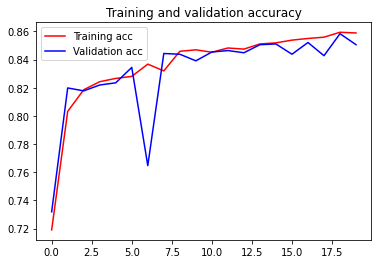

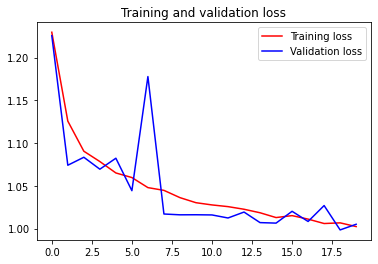

In [101]:
acc = history_fc.history['accuracy']
val_acc = history_fc.history['val_accuracy']
loss = history_fc.history['loss']
val_loss = history_fc.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

For our baseline, which is the fully connected model,the testing accuracy is 87% while the training accuracy is 85%.

# Convolutional Neural Network

In [20]:
K.clear_session()
K.set_learning_phase(1)
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)


x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.BatchNormalization()(x)


x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)


x = layers.Flatten()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
cnn_model = keras.Model(inputs=inputs, outputs=outputs,name="cnn_model")

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [21]:
cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 37, 37, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 128)       73

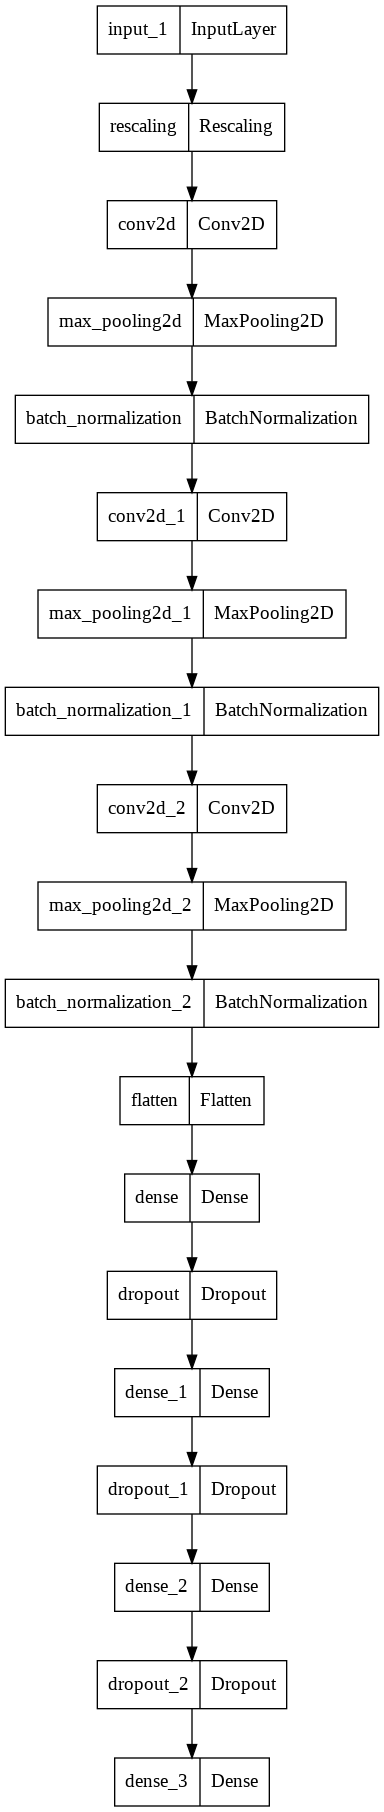

In [22]:
plot_model(cnn_model,'cnn_model.png')

In [30]:
cnn_model.compile(optimizer=optimizerSGD,
             loss='binary_crossentropy',
             metrics=['accuracy'])
callbacks = [
   keras.callbacks.ModelCheckpoint(
       filepath="cnn.keras",
       save_best_only=True,
       overwrite=True,
       monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001, verbose=1,cooldown=1)
]
history_cnn = cnn_model.fit(
   train_ds,
   epochs=20,
   validation_data=val_ds,
   verbose = 1,
   shuffle=True,
   callbacks=callbacks
)

Epoch 1/20
241/241 [==============================] - 29s 115ms/step - loss: 0.5457 - accuracy: 0.7430 - val_loss: 0.4334 - val_accuracy: 0.8287
Epoch 2/20
241/241 [==============================] - 28s 114ms/step - loss: 0.5355 - accuracy: 0.7522 - val_loss: 0.3664 - val_accuracy: 0.8365
Epoch 3/20
241/241 [==============================] - 28s 113ms/step - loss: 0.5098 - accuracy: 0.7656 - val_loss: 0.3458 - val_accuracy: 0.8574
Epoch 4/20
241/241 [==============================] - 28s 112ms/step - loss: 0.4914 - accuracy: 0.7670 - val_loss: 0.3465 - val_accuracy: 0.8558
Epoch 5/20
241/241 [==============================] - 28s 114ms/step - loss: 0.4884 - accuracy: 0.7702 - val_loss: 0.3392 - val_accuracy: 0.8615
Epoch 6/20
241/241 [==============================] - 28s 115ms/step - loss: 0.4760 - accuracy: 0.7807 - val_loss: 0.3433 - val_accuracy: 0.8506
Epoch 7/20
241/241 [==============================] - 28s 113ms/step - loss: 0.4746 - accuracy: 0.7820 - val_loss: 0.3272 - val_ac

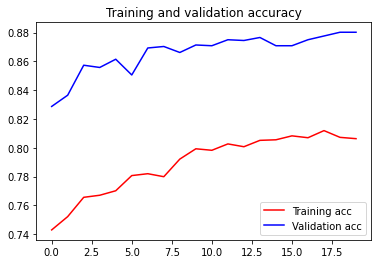

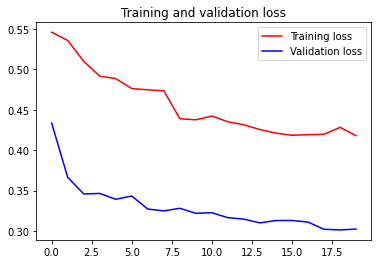

In [31]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [32]:
test_model = keras.models.load_model("cnn.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 72ms/step - loss: 0.2768 - accuracy: 0.8820
Test accuracy: 0.882


* Training time is much shorter and achieving better accuracy rate. We can see that the validation loss is lower than training loss as well, thus the model is not overfitting

* Test accuracy is 88%, an improvement from fully connected layers

# TRANSFER LEARNING

* We will take advantage of pretrained model such as vgg16

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
  weights='imagenet',
  include_top=False)
conv_base.trainable = False

In [ ]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

vgg_model = keras.Model(inputs, outputs)
vgg_model.compile(loss="binary_crossentropy",
              optimizer=optimizerSGD,
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="vgg.keras",
        save_best_only=True,
        monitor="val_loss")
]


history_vgg = vgg_model.fit(
   train_ds,
   epochs=20,
   validation_data=val_ds,
   verbose = 1,
   shuffle=True,
   callbacks=callbacks
)

Epoch 1/20
241/241 [==============================] - 27s 104ms/step - loss: 6.7593 - accuracy: 0.8378 - val_loss: 3.9894 - val_accuracy: 0.8844
Epoch 2/20
241/241 [==============================] - 26s 105ms/step - loss: 2.5784 - accuracy: 0.8647 - val_loss: 1.8088 - val_accuracy: 0.8579
Epoch 3/20
241/241 [==============================] - 26s 106ms/step - loss: 0.7337 - accuracy: 0.8636 - val_loss: 0.9030 - val_accuracy: 0.8090
Epoch 4/20
241/241 [==============================] - 26s 107ms/step - loss: 0.4433 - accuracy: 0.8667 - val_loss: 0.6528 - val_accuracy: 0.8090
Epoch 5/20
241/241 [==============================] - 26s 107ms/step - loss: 0.4038 - accuracy: 0.8809 - val_loss: 0.3501 - val_accuracy: 0.8990
Epoch 6/20
241/241 [==============================] - 26s 107ms/step - loss: 0.4138 - accuracy: 0.8812 - val_loss: 0.4521 - val_accuracy: 0.8912
Epoch 7/20
241/241 [==============================] - 26s 107ms/step - loss: 0.4263 - accuracy: 0.8814 - val_loss: 0.4561 - val_ac

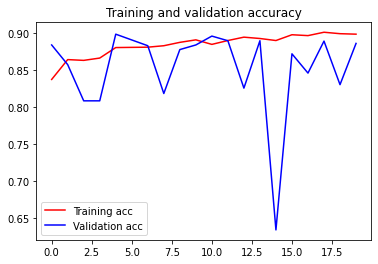

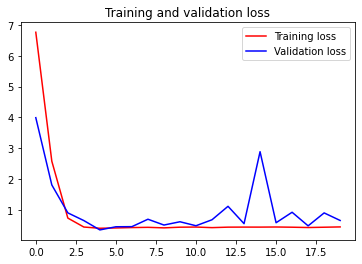

In [ ]:
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_model = keras.models.load_model("vgg.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 85ms/step - loss: 0.6340 - accuracy: 0.8930
Test accuracy: 0.893


* With transfer learning, the test accuracy is 89%, an improvement from our CNN Model

# TRANSFER LEARNING: RESNET50

In [9]:
conv_base_res  = keras.applications.resnet50.ResNet50(
  weights='imagenet',
  include_top=False)
conv_base_res.trainable = False

In [10]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base_res(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

res_model = keras.Model(inputs, outputs)
res_model.compile(loss="binary_crossentropy",
              optimizer=optimizerSGD,
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="res.keras",
        save_best_only=True,
        monitor="val_loss")
]


history_res = res_model.fit(
   train_ds,
   epochs=20,
   validation_data=val_ds,
   verbose = 1,
   shuffle=True,
   callbacks=callbacks
)

Epoch 1/20
241/241 [==============================] - 797s 3s/step - loss: 2.1789 - accuracy: 0.7896 - val_loss: 1.0769 - val_accuracy: 0.8610
Epoch 2/20
241/241 [==============================] - 45s 183ms/step - loss: 1.1856 - accuracy: 0.8238 - val_loss: 0.4556 - val_accuracy: 0.8948
Epoch 3/20
241/241 [==============================] - 44s 182ms/step - loss: 0.7642 - accuracy: 0.8397 - val_loss: 0.4302 - val_accuracy: 0.8798
Epoch 4/20
241/241 [==============================] - 45s 184ms/step - loss: 0.5878 - accuracy: 0.8390 - val_loss: 0.2884 - val_accuracy: 0.9027
Epoch 5/20
241/241 [==============================] - 45s 183ms/step - loss: 0.4508 - accuracy: 0.8559 - val_loss: 0.2683 - val_accuracy: 0.9011
Epoch 6/20
241/241 [==============================] - 45s 184ms/step - loss: 0.4056 - accuracy: 0.8552 - val_loss: 0.2483 - val_accuracy: 0.9032
Epoch 7/20
241/241 [==============================] - 45s 183ms/step - loss: 0.3565 - accuracy: 0.8673 - val_loss: 0.2442 - val_accu

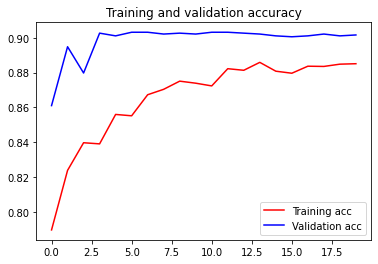

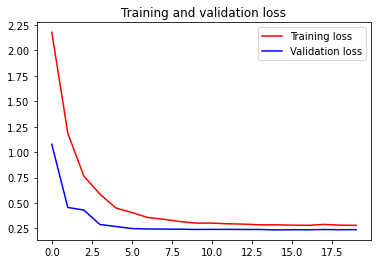

In [11]:
acc = history_res.history['accuracy']
val_acc = history_res.history['val_accuracy']
loss = history_res.history['loss']
val_loss = history_res.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
test_model = keras.models.load_model("res.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 135s 3s/step - loss: 0.2419 - accuracy: 0.9010
Test accuracy: 0.901


Thus the Resnet 50 has the best performance amongst the models that we have tried, with the accuracy rate of 90%

# ERROR ANALYSIS

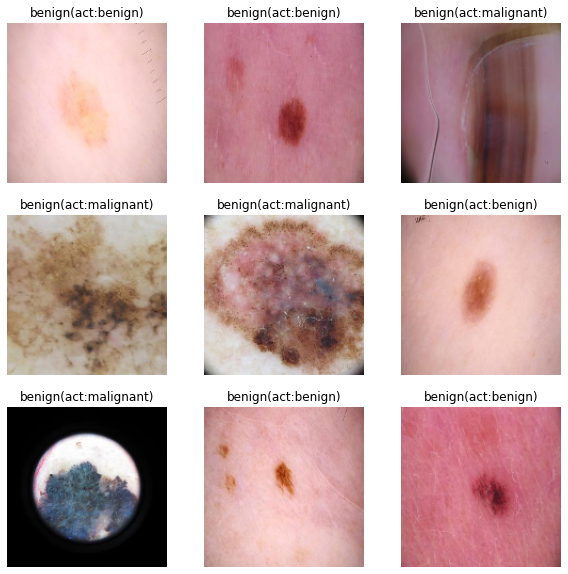

In [66]:
random_test = random.sample(test_ds.file_paths, 9)
plt.figure(figsize=(10,10))

for i,image_path in enumerate(random_test):
    actual = image_path.split("/")[-2]
    img = keras.preprocessing.image.load_img(
    image_path, target_size=(150,150)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    shown_image = img_array
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = res_model.predict(img_array)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(shown_image.astype("uint8"))
    # actual is in brackets
    plt.title(class_names[np.argmax(predictions, axis=None, out=None)] + "(act:{})".format(actual))
    plt.axis("off")

- Some of the malignant are being misclassified as benign. Thus it is worth exploring to oversample the malignant class. This would eventually improve our accuracy score

# CONCLUSION AND NEXT STEP

- For all our models, the testing accuracy is higher than the training accuracy. Thus our models don't overfit and our data augmentation works. 
- The pretrained model converges faster, however they seem to overfit and with a more fickle loss curves
- The ResNet50 model has the best performance and loss curves
- Thus, depending on our needs, we can still use our convolutional network with significant accuracy. However, it's worth exploring other state-of-the-art models
- Possible next steps include: train on more epochs, looking at more regularization method, experiment with different optimizers, kernel regularizers, etc...